### 实战七：手把手教你用TensorFlow进行验证码识别（中）

### 目录
 
 - 准备模型开发环境
 - 生成验证码数据集
 - 输入与输出数据处理
 - 模型结构设计
 - 模型损失函数设计
 - 模型训练过程分析
 - 模型部署与效果演示

### 四、模型结构设计

**1.图像分类模型AlexNet**

<img src="./imgs/7.jpg" width=650>

**2.图像分类模型VGG-16**

<img src="./imgs/8.jpg" width=650>

**3.验证码识别模型结构**

<img src="./imgs/9.jpg" width=650>

**4.验证码识别模型实现**

**a.引入第三方包**

In [1]:
from PIL import Image
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.models import *
from keras.layers import *

import glob
import pickle

import numpy as np
import tensorflow.gfile as gfile
import matplotlib.pyplot as plt

Using TensorFlow backend.


**b.变量以及函数定义**

**定义超参数和字符集**

In [34]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LOWERCASE = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']
UPPERCASE = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
           'V', 'W', 'X', 'Y', 'Z']

CAPTCHA_CHARSET = NUMBER   # 验证码字符集
CAPTCHA_LEN = 4            # 验证码长度
CAPTCHA_HEIGHT = 60        # 验证码高度
CAPTCHA_WIDTH = 160        # 验证码宽度

TRAIN_DATA_DIR = '.\\train-data\\' # 验证码数据集目录
TEST_DATA_DIR = '.\\test-data\\'

BATCH_SIZE = 100
EPOCHS = 10
OPT = 'adam'
LOSS = 'binary_crossentropy'

MODEL_DIR = './model/train_demo/'
MODEL_FORMAT = '.h5'
HISTORY_DIR = './history/train_demo/'
HISTORY_FORMAT = '.history'

filename_str = "{}captcha_{}_{}_bs_{}_epochs_{}{}"

# 模型网络结构文件
MODEL_VIS_FILE = 'captcha_classfication' + '.png'
# 模型文件
MODEL_FILE = filename_str.format(MODEL_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), MODEL_FORMAT)
# 训练记录文件
HISTORY_FILE = filename_str.format(HISTORY_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), HISTORY_FORMAT)

**将RGB验证码图像转为灰度图**

In [3]:
def rgb2gray(img):
    # Y' = 0.299 R + 0.587 G + 0.114 B 
    # https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

**对验证码中每个字符进行one-hot编码**

In [4]:
# 定义one-hot编码函数
# CAPTCHA_CHARSET = NUMBER   # 验证码字符集
# CAPTCHA_LEN = 4            # 验证码长度
def text2vec(text,length=CAPTCHA_LEN,charset=CAPTCHA_CHARSET):
    text_len = len(text)
    # 验证码长度校验
    if text_len != length:
        raise ValueError("Error:length of captcha should be{},but got {}".format(length,text_len))
    # 生成一个形如(CAPTCHA_LEN*CAPTCHA_CHARSET)的一维向量
    # 例如，4个纯数字的验证码生成形如(4*10,)的一维向量
    vec = np.zeros(length*len(charset))
    for i in range(length):
        # One-hot编码验证码中的每个数字
        # 每个字符的热码 = 索引 +偏移量
        vec[charset.index(text[i]) + i*len(charset)] = 1
    return vec

**将验证码向量解码为对应字符**

In [5]:
def vec2text(vector):
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    vector = np.reshape(vector, [CAPTCHA_LEN, -1])
    text = ''
    for item in vector:
        text += CAPTCHA_CHARSET[np.argmax(item)]
    return text

**适配Keras图像数据格式**

In [6]:
def fit_keras_channels(batch, rows=CAPTCHA_HEIGHT, cols=CAPTCHA_WIDTH):
    if K.image_data_format() == 'channels_first':
        batch = batch.reshape(batch.shape[0], 1, rows, cols)
        input_shape = (1, rows, cols)
    else:
        batch = batch.reshape(batch.shape[0], rows, cols, 1)
        input_shape = (rows, cols, 1)
    
    return batch, input_shape

**c.读取训练集**

In [7]:
X_train = []
Y_train = []
for filename in glob.glob(TRAIN_DATA_DIR + "*.png"):
    X_train.append(np.array(Image.open(filename)))
    Y_train.append(filename.lstrip(TRAIN_DATA_DIR).rstrip(".png"))

**d.处理训练集图像**


In [8]:
# list -> rgb(numpy)
X_train = np.array(X_train, dtype=np.float32)
# rgb -> gray
X_train = rgb2gray(X_train)
# normalize
X_train = X_train / 255
# Fit keras channels
X_train, input_shape = fit_keras_channels(X_train)

print(X_train.shape, type(X_train))
print(input_shape)

(3930, 60, 160, 1) <class 'numpy.ndarray'>
(60, 160, 1)


**e.处理训练集标签(one-hot编码)**

In [9]:
Y_train = list(Y_train)

for i in range(len(Y_train)):
    Y_train[i] = text2vec(Y_train[i])

Y_train = np.asarray(Y_train)

print(Y_train.shape, type(Y_train))
print(Y_train[0])

(3930, 40) <class 'numpy.ndarray'>
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


**f.读取测试集，处理对应图像和标签**

In [10]:
X_test = []
Y_test = []

for filename in glob.glob(TEST_DATA_DIR + "*.png"):
    X_test.append(np.array(Image.open(filename)))
    Y_test.append(filename.lstrip(TEST_DATA_DIR).rstrip("*.png"))

# list->numpy(rgb)->gray->normalization->fit keras
X_test = np.array(X_test,dtype=np.float32)
X_test = rgb2gray(X_test)
X_test = X_test / 255
X_test,_ = fit_keras_channels(X_test)

Y_test = list(Y_test)
for i in range(len(Y_test)):
    Y_test[i] = text2vec(Y_test[i])

Y_test = np.asarray(Y_test)

print(X_test.shape,type(X_test))
print(Y_test.shape,type(Y_test))

(961, 60, 160, 1) <class 'numpy.ndarray'>
(961, 40) <class 'numpy.ndarray'>


**g.创建验证码识别模型**

In [11]:
# 输入层
inputs = Input(shape = input_shape,name = "inputs")

# 第1层卷积
conv1 = Conv2D(32,(3,3),name="conv1")(inputs)
relu1 = Activation("relu",name="relu1")(conv1)

# 第2层卷积
conv2 = Conv2D(32,(3,3),name ="conv2")(relu1)
relu2 = Activation("relu",name="relu2")(conv2)
pool2 = MaxPooling2D(pool_size=(2,2),padding="same",name="pool2")(relu2)

# 第3层卷积
conv3 = Conv2D(64,(3,3),name="conv3")(pool2)
relu3 = Activation("relu",name="relu3")(conv3)
pool3 = MaxPooling2D(pool_size=(2,2),padding="same",name="pool3")(relu3)

# 将Pooled feature map 摊平后输入全连接网络
x = Flatten()(pool3)

# Dropout
x = Dropout(0.25)(x)

# 4个全连接层分别做10分类，分别对应4个字符
x = [Dense(10,activation="softmax",name="fc%d"%(i+1))(x) for i in range(4)]

# 4个字符向量拼接在一起，与标签向量形式一致，作为模型输出
outs = Concatenate()(x)

# 定义模型的输入与输出
model = Model(inputs=inputs,outputs=outs)
model.compile(optimizer=OPT,loss=LOSS,metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# 查看模型摘要
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 60, 160, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 58, 158, 32)  320         inputs[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 58, 158, 32)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 56, 156, 32)  9248        relu1[0][0]                      
__________________________________________________________________________________________________
relu2 (Act

**h.训练模型**

In [13]:
# 模型可视化
plot_model(model,to_file=MODEL_VIS_FILE,show_shapes=True)

In [14]:
# 训练模型
history = model.fit(X_train,
                   Y_train,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=2,
                   validation_data=(X_test,Y_test))

Instructions for updating:
Use tf.cast instead.
Train on 3930 samples, validate on 961 samples
Epoch 1/10
 - 57s - loss: 0.3288 - acc: 0.9000 - val_loss: 0.3258 - val_acc: 0.9000
Epoch 2/10
 - 50s - loss: 0.3254 - acc: 0.9000 - val_loss: 0.3255 - val_acc: 0.9000
Epoch 3/10
 - 58s - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000
Epoch 4/10
 - 53s - loss: 0.3249 - acc: 0.9000 - val_loss: 0.3245 - val_acc: 0.9000
Epoch 5/10
 - 54s - loss: 0.3192 - acc: 0.9000 - val_loss: 0.3083 - val_acc: 0.9002
Epoch 6/10
 - 54s - loss: 0.2752 - acc: 0.9035 - val_loss: 0.2717 - val_acc: 0.9040
Epoch 7/10
 - 52s - loss: 0.2237 - acc: 0.9170 - val_loss: 0.2407 - val_acc: 0.9121
Epoch 8/10
 - 53s - loss: 0.1906 - acc: 0.9287 - val_loss: 0.2218 - val_acc: 0.9188
Epoch 9/10
 - 53s - loss: 0.1613 - acc: 0.9400 - val_loss: 0.2158 - val_acc: 0.9231
Epoch 10/10
 - 52s - loss: 0.1345 - acc: 0.9510 - val_loss: 0.2262 - val_acc: 0.9218


**i.预测样例**

In [26]:
# 真实值
print(vec2text(Y_test[5]))

0044


In [27]:
# 预测值
yy = model.predict(X_test[5].reshape(1,60,160,1))
print(vec2text(yy))

0144


**j.保存模型**

In [37]:
if not gfile.Exists(MODEL_DIR):
    gfile.MakeDirs(MODEL_DIR)

model.save(MODEL_FILE)
print("saved trained model at %s" %MODEL_FILE)

saved trained model at ./model/train_demo/captcha_adam_binary_crossentropy_bs_100_epochs_10.h5


**k.保存训练过程记录**

In [38]:
history.history["acc"]

[0.8999997987091997,
 0.8999997987091997,
 0.8999997987091997,
 0.8999997987091997,
 0.8999997987091997,
 0.903492193943975,
 0.9169528651176821,
 0.9287086367303785,
 0.9400127452748422,
 0.9510496704632999]

In [39]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [41]:
if gfile.Exists(HISTORY_DIR) == False:
    gfile.MakeDirs(HISTORY_DIR)

with open(HISTORY_FILE,"wb") as f:
    pickle.dump(history.history,f)

In [42]:
print(HISTORY_FILE)

./history/train_demo/captcha_adam_binary_crossentropy_bs_100_epochs_10.history


### 五、模型损失函数设计

**1.交叉熵（Cross-Entropy，CE）**

<img src="./imgs/10.jpg" width=650>

**2.Categorical CE Loss(Softmax Loss)**

<img src="./imgs/11.jpg" width=650>

**3.Binary CE Loss(Sigmoid CE LOSS)**

<img src="./imgs/12.jpg" width=650>

**4.不同损失函数对比**

**a.引入第三方包**

In [43]:
import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

**b.定义过程可视化方法**

In [44]:
def plot_training(history=None, metric='acc', title='Model Accuracy', loc='lower right'):
    model_list = []
    fig = plt.figure(figsize=(10, 8))
    for key, val in history.items():
        model_list.append(key.replace(HISTORY_DIR, '').rstrip('.history'))
        plt.plot(val[metric])

    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(model_list, loc=loc)
    plt.show()

**c.加载预训练模型**

In [45]:
HISTORY_DIR = './pre-trained/history/loss/'
history = {}
for filename in glob.glob(HISTORY_DIR + '*.history'):
    with open(filename, 'rb') as f:
        history[filename] = pickle.load(f)

In [46]:
for key, val in history.items():
    print(key.replace(HISTORY_DIR, '').rstrip('.history'), val.keys())

./pre-trained/history/loss\captcha_rmsprop_binary_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
./pre-trained/history/loss\captcha_rmsprop_categorical_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
./pre-trained/history/loss\captcha_rmsprop_mse_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
./pre-trained/history/loss\captcha_rmsprop_poisson_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


**d.准确率变化（训练集）**

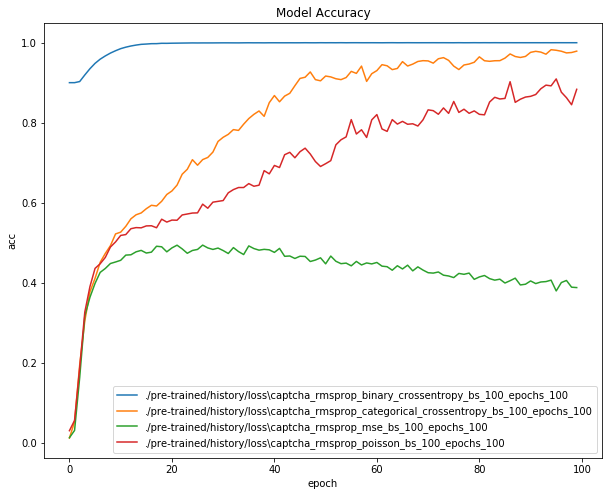

In [47]:
# del history[HISTORY_DIR+'captcha_rmsprop_categorical_crossentropy_bs_100_epochs_100'+'.history']
plot_training(history)

**e.损失值变化(训练集)**

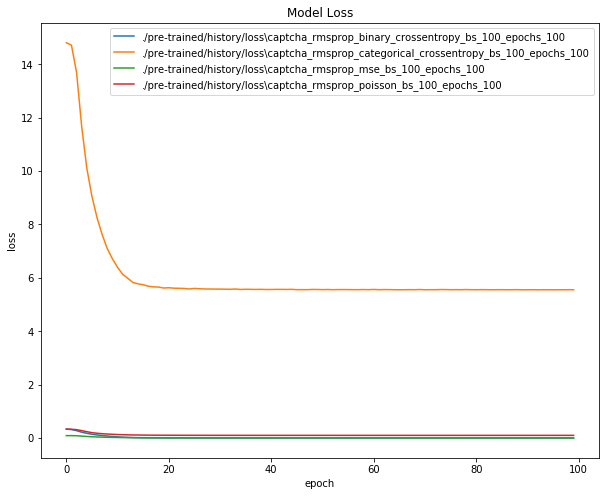

In [48]:
plot_training(history, metric='loss', title='Model Loss', loc='upper right')

**f.准确率变化（测试集）**

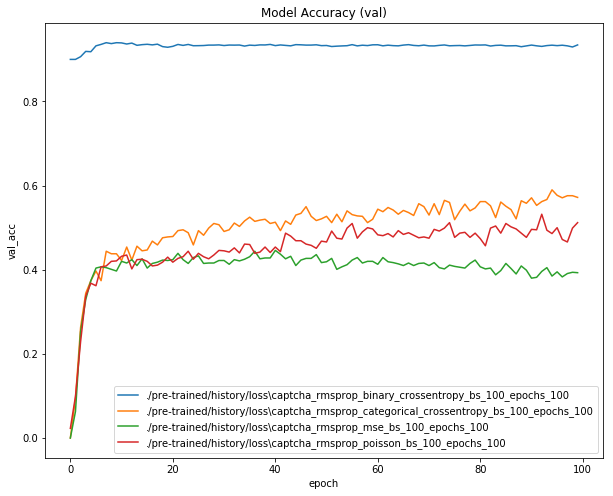

In [49]:
plot_training(history, metric='val_acc', title='Model Accuracy (val)')

**g.损失值变化(测试集)**

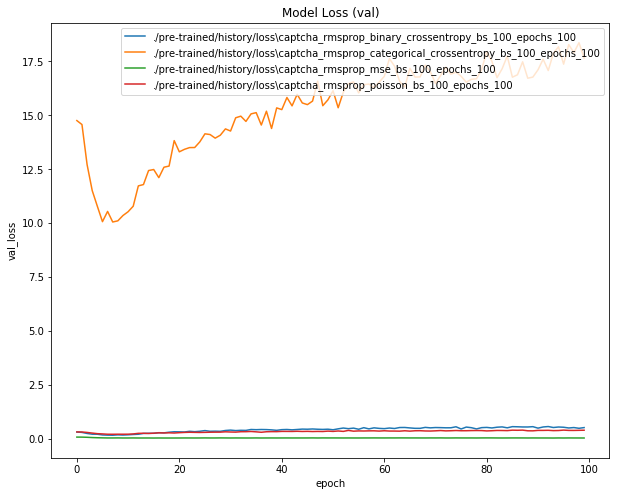

In [50]:
plot_training(history, metric='val_loss', title='Model Loss (val)', loc='upper right')

### 六、模型训练过程分析

**1.优化器介绍:SGD(Stochastic Gradient Descent)**

<img src="./imgs/13.jpg" width=650>

**2.优化器介绍：SGD-M（Momentum）**

<img src="./imgs/14.jpg" width=650>

**3.优化器介绍：Adagrad-RMSprop-Adam**

<img src="./imgs/15.jpg" width=650>

**4.优化器对比**

**a.引入第三方包**

In [51]:
import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

**b.加载训练过程记录**

In [52]:
history_file = './pre-trained/history/optimizer/binary_ce/captcha_adam_binary_crossentropy_bs_100_epochs_100.history'
with open(history_file,"rb") as f:
    history = pickle.load(f)

**c.训练过程可视化**

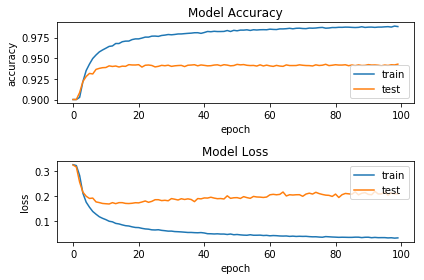

In [53]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

plt.show()

**d.定义过程可视化方法**

In [62]:
def plot_training(history=None, metric='acc', title='Model Accuracy', loc='lower right'):
    model_list = []
    fig = plt.figure(figsize=(10, 8))
    for key, val in history.items():
        model_list.append(key.replace(HISTORY_DIR, '').rstrip('.history'))
        plt.plot(val[metric])

    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(model_list, loc=loc)
    plt.show()

**e.加载预训练模型记录**

In [68]:
HISTORY_DIR = '.\\pre-trained\\history\\optimizer\\binary_ce\\'
history = {}
for filename in glob.glob(HISTORY_DIR + '*.history'):
    with open(filename, 'rb') as f:
        history[filename] = pickle.load(f)

In [69]:
for key, val in history.items():
    print(key.replace(HISTORY_DIR, '').rstrip('.history'), val.keys())

captcha_adadelta_binary_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
captcha_adagrad_binary_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
captcha_adam_binary_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
captcha_rmsprop_binary_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


**f.准确率变化(训练集)**

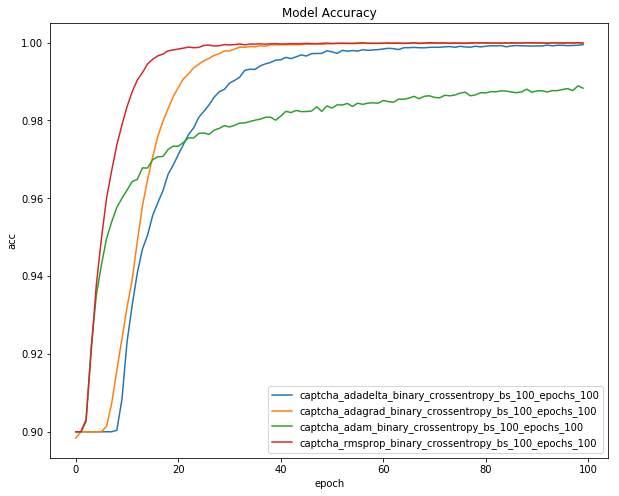

In [70]:
plot_training(history)

**g.损失值变化（训练集）**

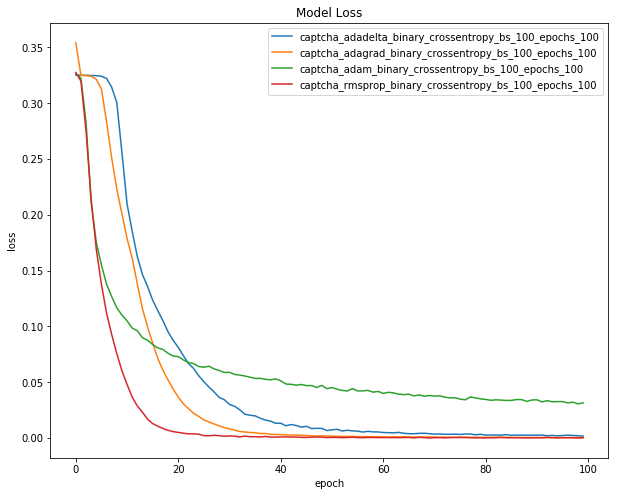

In [71]:
plot_training(history, metric='loss', title='Model Loss', loc='upper right')

**h.准确率变化（测试集）**

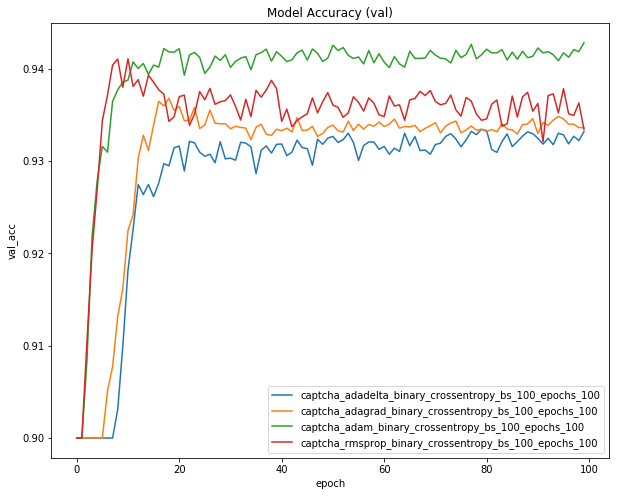

In [72]:
plot_training(history, metric='val_acc', title='Model Accuracy (val)')

**i.损失值变化（测试集）**

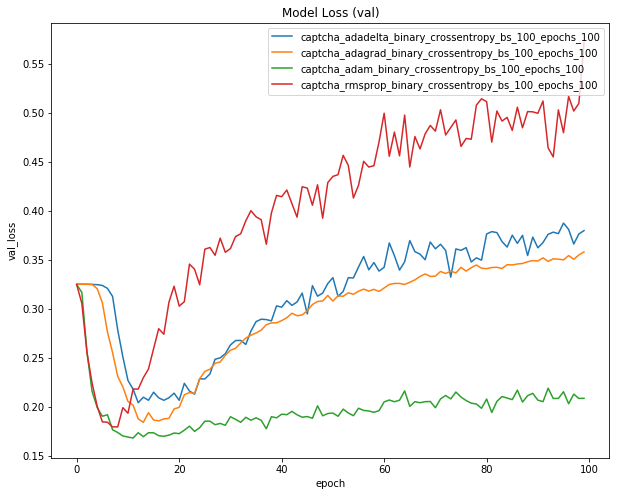

In [73]:
plot_training(history, metric='val_loss', title='Model Loss (val)', loc='upper right')